In [3]:
cd ..

/home/jovyan/dsi_plus/Projects/Project-4-semantic_search


In [4]:
%run lib/__init__.py
%matplotlib inline

# Project 4 - Semantic Search

## Latent Semantic search - model development

 - build corpus
 - vectorize with tfidf
 - reduce dimmenions with SVD
 - explore features -> amend data by cleaning and iterate from corpus build process
 - build search function

Restrict model development process to pagetest collection so that dtm and svd components and be visualied in dataframe , but recognize that the total data set will be >5000 pages and will be too much data for kernal memory if dtm loaded into a dataframe ( tried this and  kept crashing kernel). 
For production model dtm and svd data will be kept in a sparse matrix until final step.

## Load articles from 'pagestest' collection MongoDB and create ' corpus ' for search engine
If load fails..
 - check AWS instance on which DB is hosted is running and that the docker container for Mongo is runnning
 - check ip address for server hosting  Mongo DB (stored in wiki_api.py)

In [5]:
myWiki=MyWikiDB()

In [6]:
cat_loaded_cllr=myWiki.dbr.loads_collection

In [7]:
#Load history - check which categories loaded 
cursor=cat_loaded_cllr.find()
loaded=list(cursor)
pd.DataFrame(loaded)

,_id,loaded,master_cat,sub_cats_added
0,5a691422cd7a8902503aa27f,Wed Jan 24 23:17:54 2018,Category:Classification algorithms,5
1,5a6a160fcd7a8900a1f84969,Thu Jan 25 17:38:23 2018,Category:Classification algorithms,0


In [8]:
pagestest_cllr=myWiki.dbr.pagetest_collection

In [9]:
print('No. of pages loaded = {}'.format(pagestest_cllr.find().count()))

No. of pages loaded = 255


In [10]:
cursor=pagestest_cllr.find()
pages=list(cursor)

In [11]:
corpus_df=pd.DataFrame(pages[:1000])
corpus_df.head()

,_id,category_list,extract,ns,pageid,pull_category,title
0,32003319,[Category:Algorithms and data structures stubs...,approximate near neighbor search special case ...,0,32003319,Category:Classification algorithms,(1+ε)-approximate nearest neighbor search
1,740955,"[Category:Classification algorithms, Category:...",two main use term calibration statistic denote...,0,740955,Category:Classification algorithms,Calibration (statistics)
2,843901,[Category:Classification algorithms],soft independent model class analogy simca sta...,0,843901,Category:Classification algorithms,Soft independent modelling of class analogies
3,1579244,[Category:All articles lacking in-text citatio...,machine learn statistic classification problem...,0,1579244,Category:Classification algorithms,Statistical classification
4,27156903,"[Category:Classification algorithms, Category:...",statistic adaptive variable bandwidth kernel d...,0,27156903,Category:Classification algorithms,Variable kernel density estimation


In [12]:
#Remove unnecessary columns
columns_to_drop=['ns', 'category_list','pull_category', '_id']
corpus_df.drop(columns_to_drop, axis=1, inplace=True)

In [13]:
corpus_df.set_index('title', inplace=True)

In [14]:
corpus_df.head()

,extract,pageid
title,,
(1+ε)-approximate nearest neighbor search,approximate near neighbor search special case ...,32003319
Calibration (statistics),two main use term calibration statistic denote...,740955
Soft independent modelling of class analogies,soft independent model class analogy simca sta...,843901
Statistical classification,machine learn statistic classification problem...,1579244
Variable kernel density estimation,statistic adaptive variable bandwidth kernel d...,27156903


In [15]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, (1+ε)-approximate nearest neighbor search to Wolfram Language
Data columns (total 2 columns):
extract    255 non-null object
pageid     255 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


## Abreviations to use in code
* dtm = document term matrix
* dtma= augmented document term matrix - including search term
* sp = sparse as apposed to df = dataframe
* svdm= singular value decomposition matrix  - by component
* svdma= singular value decomposition augmented matrix  - including search term
* tfidf_v= TFiDF Vectorizer
* svd_v= svd vectorizer
* lsa= Latent Semantic Analysis
* sterm= search term

### Label encode the title

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

In [15]:
le=LabelEncoder()
corpus_df['title_numerical'] = le.fit_transform(corpus_df.index)

In [16]:
corpus_df.head(4)

,extract,pageid,title_numerical
title,,,
(1+ε)-approximate nearest neighbor search,approximate near neighbor search special case ...,32003319,0
Calibration (statistics),two main use term calibration statistic denote...,740955,32
Soft independent modelling of class analogies,soft independent model class analogy simca sta...,843901,225
Statistical classification,machine learn statistic classification problem...,1579244,228


### Prepare for Document Term Matrix (DTM)
Use TFIDF (Term Frequency x Inverse Document Frequency) to generate document term matrix.
 - Apply following hyperparatmeters, tests run with different values
     - remove 'english' stop words ( this was also done in cleaning proces but on testing resulting size of dtm TFIDF removes addtional stopwords.)
     - keep repeating groups of 1 to 2 words  (ngrams)  - tested with and without
     - set minimum no. of documents a term must occur in ( min_df ) - tested 1 or 2 

In [16]:
#test 1
#tfidf_v = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2), min_df=2)

In [17]:
#test 2
#tfidf_v = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2), min_df=1)

In [18]:
#test 3
tfidf_v = TfidfVectorizer(stop_words = 'english', min_df=1  )

In [19]:
%%time
dtm_sp = tfidf_v.fit_transform(corpus_df.extract)

CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 130 ms


In [20]:
dtm_sp

<255x9409 sparse matrix of type '<class 'numpy.float64'>'
	with 54873 stored elements in Compressed Sparse Row format>

In [21]:
dtm_df = pd.DataFrame(dtm_sp.toarray(),
                                       index=corpus_df.index,
                                       columns=tfidf_v.get_feature_names())

In [22]:
dtm_df.T.tail(10)

title,(1+ε)-approximate nearest neighbor search,Calibration (statistics),Soft independent modelling of class analogies,Statistical classification,Variable kernel density estimation,AdaBoost,ALOPEX,Alternating decision tree,Analogical modeling,Averaged one-dependence estimators,...,Neuro Laboratory,Neuroph,NeuroSolutions,OCRopus,Peltarion Synapse,Picas (app),Prisma (app),PSIPRED,SNNS,Wolfram Language
zoom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zquez,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zsa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ztemel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zucol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zufa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zupan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zwischen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
dtm_df.shape

(255, 9409)

### Compute SVD matrix

In [24]:
n_components = 200
svd_v = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [25]:
%%time
svdm = svd_v.fit_transform(dtm_df)

CPU times: user 990 ms, sys: 940 ms, total: 1.93 s
Wall time: 546 ms


In [26]:
sum(svd_v.explained_variance_ratio_)

0.91197912159119954

<Container object of 200 artists>

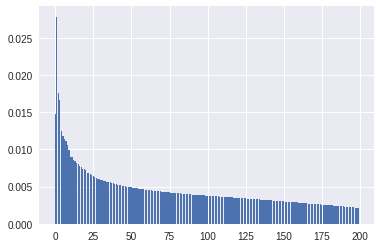

In [27]:
plt.bar(range(n_components), svd_v.explained_variance_ratio_)

In [28]:
lsa = pd.DataFrame(svdm,index=dtm_df.index,columns=component_names)
lsa['extract'] = corpus_df.extract
lsa['pageid'] = corpus_df.pageid

In [29]:
lsa.head(3)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,extract,pageid
title,,,,,,,,,,,,,,,,,,,,,
(1+ε)-approximate nearest neighbor search,0.105344,0.141604,-0.052743,-0.056402,-0.208383,-0.163134,0.312477,0.315980,-0.155686,0.406264,...,-0.012491,0.113033,0.061653,-0.056466,-0.009342,0.016228,0.027362,-0.003644,approximate near neighbor search special case ...,32003319
Calibration (statistics),0.178920,0.160914,-0.024841,-0.089675,-0.062449,-0.118057,-0.061072,-0.169123,0.000324,-0.043886,...,-0.055681,0.024109,0.011486,0.032548,-0.030170,-0.002444,-0.034641,0.014981,two main use term calibration statistic denote...,740955
Soft independent modelling of class analogies,0.223250,0.194821,-0.042294,-0.131805,-0.140503,-0.091542,0.036746,-0.126910,0.007179,-0.026745,...,-0.032190,-0.016467,0.009325,0.009909,-0.037312,0.026290,0.011859,0.011474,soft independent model class analogy simca sta...,843901


In [30]:
lsa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, (1+ε)-approximate nearest neighbor search to Wolfram Language
Columns: 202 entries, component_1 to pageid
dtypes: float64(200), int64(1), object(1)
memory usage: 404.4+ KB


In [31]:
comp_features = pd.DataFrame(svd_v.components_,index=component_names,columns=tfidf_v.get_feature_names()).T

### Look at feature breakdown of components
Lots of numbers, and symbols - need to remove

In [32]:
# Feature breakdown of componentes
top_20={}
for i in range(1,20):
    comp_features['abs_component_{}'.format(i)] = np.abs(comp_features['component_{}'.format(i)])

In [44]:
comp_features['abs_component_1'].sort_values(ascending=False).head(10)

network     0.321700
neural      0.218354
function    0.184732
learn       0.171700
use         0.169077
model       0.167996
neuron      0.157820
layer       0.151114
train       0.150770
weight      0.142871
Name: abs_component_1, dtype: float64

## Search process

1. input search term and vectorize using fitted TFIDF
2. Append search term to the DTM -> augmented DTM
3. SVD fit & transform on augemented DTM - > updated components
4. identify index for search term vector in svd matrix
5. Use cosine similarity to find most similar vectors in svd matrix

In [47]:
search_term='logistic regression'

In [48]:
s_term=[search_term]

#vectorize search term with TFIDF vectorizer (previously fitted)
s_term_encoded=tfidf_v.transform(s_term)
s_term_encoded_df = pd.DataFrame(s_term_encoded.toarray(), 
                                   index=['search_term'], 
                                   columns=tfidf_v.get_feature_names())

In [49]:
s_term_encoded_df

,aaai,aalto,aamodt,ab,abandon,abbreviate,abbreviation,abdoman,abductive,abello,...,zoom,zquez,zs,zsa,ztemel,zucol,zufa,zupan,zur,zwischen
search_term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
dtma_df=()

In [51]:
%%time
#add to existing document term matrix
dtma_df=dtm_df.append(s_term_encoded_df)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 4.38 ms


In [52]:
dtma_df.shape

(256, 9409)

In [53]:
%%time
#re fit SVD to augmented document term matrix
component_names = ["component_"+str(i+1) for i in range(svd_v.n_components)]
svdma=svd_v.fit_transform(dtma_df)
svdma_df=pd.DataFrame(svdma,index=dtma_df.index,columns=component_names)

CPU times: user 1.22 s, sys: 1.12 s, total: 2.34 s
Wall time: 592 ms


In [54]:
#find index of search term in refit SVD matrix
s_term_svd_vector=svdma_df.loc['search_term',:].values.reshape(1,-1)

In [55]:
#calculate cosine similarty of search term against other SVD vectors
svdma_df['cosine_sim'] = cosine_similarity(svdma_df, s_term_svd_vector)

In [56]:
print('top 10 wiki pages that are related to search term = {}'.format(s_term))
svdma_df[['cosine_sim']].sort_values('cosine_sim', ascending=False).head(10)
    

top 10 wiki pages that are related to search term = ['logistic regression']


,cosine_sim
search_term,1.000000
Logistic model tree,0.424527
Multinomial logistic regression,0.384367
Sigmoid function,0.356528
LogitBoost,0.261227
Softmax function,0.213660
Statistical classification,0.135483
Optimal discriminant analysis,0.129338
Calibration (statistics),0.126334
General regression neural network,0.115813


# Assessing search results

Search engine results were measured against the top google search results from the en.wikipedia site.
In google search...
 -  ' site:en.wikipedia.org SEARCHTERM '
 
Tfidif version 3 gave the most comparable search with an average of 3 of the top 9 google results appearing in the search engine results.

version 3 : tfidf_v = TfidfVectorizer(stop_words = 'english', min_df=1  )

These parameters where use in the final model build.


This was a good performance given the google search was over the entire en.wikipedia content. Many of the items not picked up where not included in the MongoDB content.

The full results are in provided in the excel workbook ' search-engine-tests.xlsx'